In [0]:
import urllib
##Chigaco crashes import
urllib.request.urlretrieve("https://data.cityofchicago.org/api/views/85ca-t3if/rows.csv", "/tmp/trafic_crashes.csv")

In [0]:
##Move to dbfs
dbutils.fs.mv("file:/tmp/trafic_crashes.csv", "dbfs:/tmp/trafic_crashes.csv")

In [0]:
from pyspark.sql.functions import to_timestamp, to_date, hour, month, col
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
df = spark.read.format("csv").options(header = True, Delimiter = ',', inferSchema = True).load("/tmp/trafic_crashes.csv")
display(df.select('CRASH_DATE').limit(10))

df=df.withColumn('CRASH_DATE_FORMATED',to_timestamp('CRASH_DATE',"MM/dd/yyyy hh:mm:ss a"))

##Exploring the data throught queries
##min and max des jours accidents
df.select(F.min('CRASH_DATE_FORMATED'),F.max('CRASH_DATE_FORMATED')).display()

##nb de jours d'accidents
df = df.withColumn("CRASH_DAY", to_date("CRASH_DATE_FORMATED"))
distinct_days_count = df.select("CRASH_DAY").distinct().count()
print(distinct_days_count)


CRASH_DATE
09/05/2023 07:05:00 PM
09/22/2023 06:45:00 PM
07/29/2023 02:45:00 PM
08/09/2023 11:00:00 PM
08/18/2023 12:50:00 PM
11/26/2019 08:38:00 AM
02/06/2023 05:30:00 PM
01/31/2022 07:45:00 PM
01/01/2022 04:32:00 PM
10/18/2020 03:58:00 PM


min(CRASH_DATE_FORMATED),max(CRASH_DATE_FORMATED)
2013-03-03T16:48:00Z,2023-11-28T23:09:00Z


3074


In [0]:
# Group by hour : Repartition des accidents selon les heures
df = df.withColumn("hour", hour("CRASH_DATE_FORMATED"))
crashes_per_hour = df.groupBy("hour").count().orderBy("hour")
display(crashes_per_hour.limit(10))

# Group by month : Repartition des accidents selon les mois
df = df.withColumn("month", month("CRASH_DATE_FORMATED"))
crashes_per_month = df.groupBy("month").count().orderBy("month")
display(crashes_per_month.limit(10))

hour,count
0,17001
1,14533
2,12501
3,10169
4,9083
5,10773
6,17029
7,33077
8,41325
9,36007


month,count
1,57832
2,57482
3,58886
4,57161
5,66528
6,67555
7,68960
8,70892
9,72403
10,76784


In [0]:
##load weather data from dbfs
chicago_weather1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/chigaco_weather/Chigaco_weather_2017_to_2023.csv")
chicago_weather2 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/chigaco_weather/Chigaco_weather_2013_to_2017.csv")

chicago_weather = chicago_weather2.union(chicago_weather1)

display(chicago_weather.select(F.min('date'),F.max('date')))

min(date),max(date)
2013-01-01,2023-11-23


In [0]:
##Crash and weather
crash_join_weather = df.join(chicago_weather, chicago_weather["date"] == df["CRASH_DAY"], "inner")

##Accident et température moyenne, vent et pluie
crashes_per_day_weather = crash_join_weather.select("CRASH_DAY", "tavg","wspd","prcp") \
    .groupBy("CRASH_DAY", "tavg","wspd","prcp") \
    .agg(F.count("*").alias("crash_count"))

display(crashes_per_day_weather.limit(10))



CRASH_DAY,tavg,wspd,prcp,crash_count
2022-01-30,-6.3,9.7,0,211
2023-07-30,23.3,11.5,0,298
2020-08-29,26.6,19.4,0,302
2016-10-14,10.1,12.2,0,187
2021-09-27,23,19.1,0,320
2018-02-07,-8.5,15.1,2.8,271
2022-03-12,-8.1,21.2,0,319
2020-06-20,27.8,15.5,4.8,379
2021-11-11,11.5,20.5,11.2,292
2021-03-03,6.8,13.3,0,278


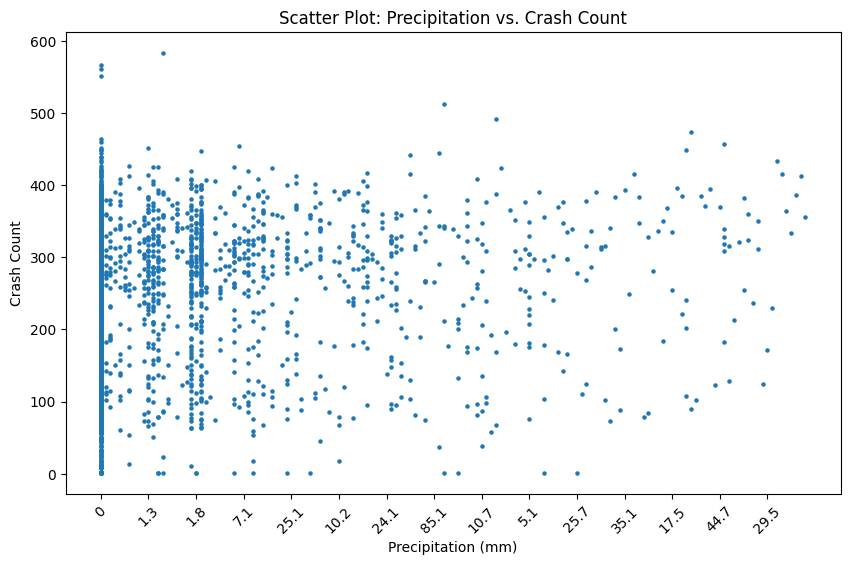

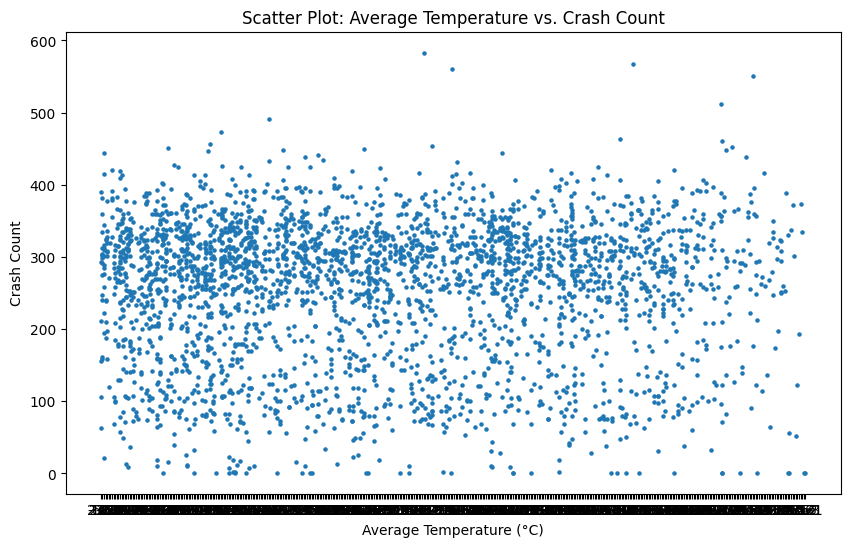

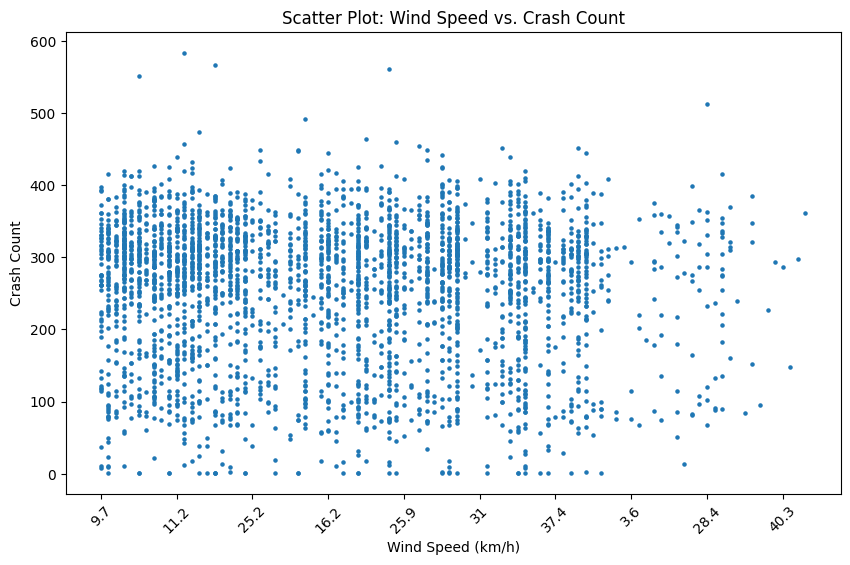

In [0]:
#Visulisation des résultats

result_pd = crashes_per_day_weather.toPandas()

# Scatter for precipitation (prcp)
plt.figure(figsize=(10, 6))
plt.scatter(result_pd['prcp'], result_pd['crash_count'],s = 5)
plt.title('Scatter Plot: Precipitation vs. Crash Count')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Crash Count')
plt.xticks(rotation=45, ticks=result_pd['prcp'].unique()[::10])
plt.show()

# Scatter for average temperature (tavg)
plt.figure(figsize=(10, 6))
plt.scatter(result_pd['tavg'], result_pd['crash_count'],s = 5)
plt.title('Scatter Plot: Average Temperature vs. Crash Count')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Crash Count')
plt.show()

# Scatter for wind speed (wspd)
plt.figure(figsize=(10, 6))
plt.scatter(result_pd['wspd'], result_pd['crash_count'],s = 5)
plt.title('Scatter Plot: Wind Speed vs. Crash Count')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Crash Count')
plt.xticks(rotation=45, ticks=result_pd['wspd'].unique()[::10])
plt.show()